In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define a transform to convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the CIFAR-10 training set
trainset = torchvision.datasets.CIFAR10(root='~/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=False)

# Define class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Get one batch (the first image)
dataiter = iter(trainloader)
images, labels = next(dataiter)

# imageoriginal_imgs = images.to("cuda")
# labels = labels.to("cuda")

Files already downloaded and verified


In [19]:
images =  images.squeeze().permute(1,2,0).cpu().numpy()

In [3]:
import inversefed
setup = inversefed.utils.system_startup()

dm = torch.as_tensor(inversefed.consts.cifar10_mean, **setup).reshape(-1, 1,1)
ds = torch.as_tensor(inversefed.consts.cifar10_std, **setup).reshape(-1,1,1)

def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

Currently evaluating -------------------------------:
Tuesday, 21. October 2025 09:11AM
CPUs: 4, GPUs: 1 on bm1-System-Product-Name.
GPU : NVIDIA GeForce GTX 1060 6GB


In [4]:
arch = 'ConvNet64'
num_images = 1
trained_model = False

In [5]:
import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')
loss_fn, _, _ =  inversefed.construct_dataloaders('CIFAR10', defs, shuffle = False)
model, _ =                           inversefed.construct_model(arch, num_classes=10, num_channels=3)
model.to(**setup);

Currently evaluating -------------------------------:
Tuesday, 21. October 2025 09:11AM
CPUs: 4, GPUs: 1 on bm1-System-Product-Name.
GPU : NVIDIA GeForce GTX 1060 6GB
Files already downloaded and verified
Files already downloaded and verified
Model initialized with random key 3618494113.


In [6]:
model.eval();

In [ ]:
ground_truth = images.sub(dm).div(ds).contiguous().to(**setup)

In [8]:
model.zero_grad()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach() for grad in input_gradient]

It: 0. Rec. loss: 0.0074.
It: 500. Rec. loss: 0.0014.
It: 1000. Rec. loss: 0.0016.
It: 1500. Rec. loss: 0.0018.
It: 2000. Rec. loss: 0.0013.
It: 2500. Rec. loss: 0.0010.
It: 3000. Rec. loss: 0.0007.
It: 3500. Rec. loss: 0.0008.
It: 3999. Rec. loss: 0.0008.
Choosing optimal result ...
Optimal result score: 0.0008
Total time: 72.19013166427612.


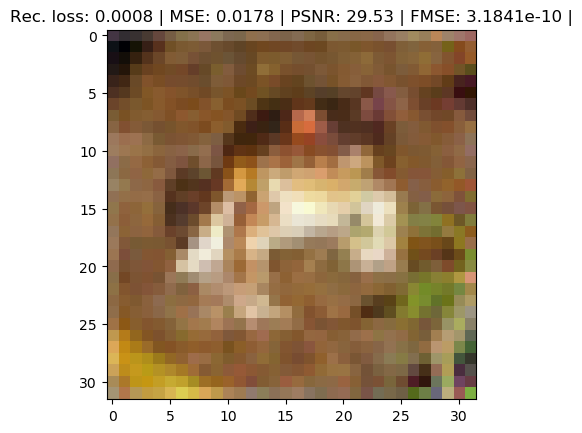

In [143]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=1,
              max_iterations=4000,
              total_variation=1e-6,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=num_images)

output, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(3, 32, 32))

test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, ground_truth, factor=1/ds)

plot(output)
plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
          f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");